## NLP for comments on Port Royale 4

This game is 1 of my favorite trading games. However, it has recevied very complex reviews since day 1 of its release. It also started out in a  bad shape upon its release and was remedied by subsequent updates. 

Thus, for any regular gamer coming to this game on Steamd, he/she will unlikely purchase this game. Furthermore, this game has received several hundres of reviews presented in mixed languages. As a result, even a potential lover of this game will find him/herself reluctant to make any purcahse decision by going through the customer reviews.

My intent here is to perform semtiment analyses, a branch of natural language processing (NLP), on the publicly accessible reviews of this game. The first aim is to provide more information for users. 2nd..... Finally, as a part of a future goal, I want to automate the analyses process over several thousands of game to identify the most rated features for games at each category, and subsequently make a forcast model about the sale of future games with or without certain features.

#Disclaimer:

This project is in large part based on an estabilished package for working with steam: https://pypi.org/project/steamreviews/.
P.S. Also, there appears to be a limit in data one can download. This limit is not removed here for the moment.

In [185]:
import steamreviews


#port royale 4 (mixed)
gameID1 = 1024650
#port royale 3 (mostly positive)
gameID2 = 205610
#port royale 2 (mixed)
gameID3 = 12470
gameIDs = [gameID1, gameID2, gameID3]
steamreviews.download_reviews_for_app_id_batch(gameIDs)

Loading idprocessed_on_20210419.txt
Skipping previously found appID = 1024650
Skipping previously found appID = 205610
Skipping previously found appID = 12470
Game records written: 0


True

In [186]:
import json
import pandas as pd
import os
from io import StringIO

In [187]:
def extract_reviews_to_csv(gameID):
    json_path = 'data/review_' + str(gameID) +'.json'
    json_abspath = os.path.abspath(json_path)
    f = open(json_abspath, 'r')
    data = json.load(f)
    review_list = []
    #Below, we make use of the fact that
    #each review stored in 'data['reviews']' is stored as a tuple {user ID, details of the review},
    #and each 'details of the review' is itself a dictationary.
    #This can be converted into a nested dictinoary using data['reviews'].items(), so that user ID
    #become the key and the details of the review becomes the corresponding value.
    for user_id, review_info in data['reviews'].items():
        #For each item, we build our own disctionary, selecting info we care at the moment
        review_select = {
            'Steam ID': user_id,
            'Review': review_info['review'],
            'Language': review_info['language'],
            'Recommended': review_info['voted_up'],
            'Play time': review_info['author']['playtime_forever'],
            'Purchase': review_info['steam_purchase']
        }
        review_list.append(review_select)
    review_deposit = json.dumps(review_list, indent=4)
    #convert json object to csv
    df = pd.read_json(StringIO(review_deposit))
    out_file_name = os.path.dirname(json_abspath) + '/review_' + str(gameID) + '.csv'
    df.to_csv(out_file_name, index=False, encoding='utf-8')
    print('Reviews being saved to:', out_file_name)

In [188]:
for gameID in gameIDs: extract_reviews_to_csv(gameID)

Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Coding_challenge/Q1/data/review_1024650.csv
Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Coding_challenge/Q1/data/review_205610.csv
Reviews being saved to: /Users/delcck/Desktop/Research/ML_AI/Coding_challenge/Q1/data/review_12470.csv


### Build dataFrame objects for later analyses

In [189]:
def build_pd(gameID):
    json_path = 'data/review_' + str(gameID) +'.csv'
    json_abspath = os.path.abspath(json_path)
    df = pd.read_csv(json_abspath)
    #We at this stage only analyze reviews in English.
    df = df[df['Language'] == 'english']
    df['Review'] = df['Review'].astype(str)
    #remove unnecessary key
    df = df.drop(['Steam ID'], axis=1)
    #add a key for word count in the review
    df['Length'] = df['Review'].apply(lambda x : len(x.split()))
    recommend_df = df[df['Recommended'] == True]
    recommend_df = recommend_df.reset_index(drop=True)
    not_recommend_df = df[df['Recommended'] == False]
    not_recommend_df = not_recommend_df.reset_index(drop=True)
    return recommend_df, not_recommend_df

In [190]:
recommend_df_L = []
not_recommend_df_L = []
for gameID in gameIDs:
    df1, df2 = build_pd(gameID)
    recommend_df_L.append(df1)
    not_recommend_df_L.append(df2)

#### Perform a word count analyses

In [191]:
import matplotlib.pyplot as plt

game_name_L =['Port royale 4', 'Port royale 3', 'Port ryoale 2']

In [177]:
def plot_word_count(recommend_df_L, not_recommend_df_L, game_name_L):

    num_row = len(game_name_L)
    plt.figure(figsize=(9,9))
    j = num_row
    for i in range(0,num_row):
        k = i * 2 + 1
        plt.subplot(j,2,k)
        plt.title(game_name_L[i], fontsize=14)
        plt.hist(recommend_df_L[i]['Length'].values, bins=6)
        plt.xlabel('Word count of \'Recommended\' reviews', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xlim(-0.5,1400)
        plt.ylim(0,250)
        plt.tight_layout(pad=3.0)

    for i in range(0,num_row):
        k = i * 2 + 2
        plt.subplot(j,2,k)
        plt.title(game_name_L[i], fontsize=14)
        plt.hist(not_recommend_df_L[i]['Length'].values, bins=6)
        plt.xlabel('Word count of \'Not Recommended\' reviews', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xlim(-0.5,1400)
        plt.ylim(0,250)
        plt.tight_layout(pad=3.0)

    plt.show()

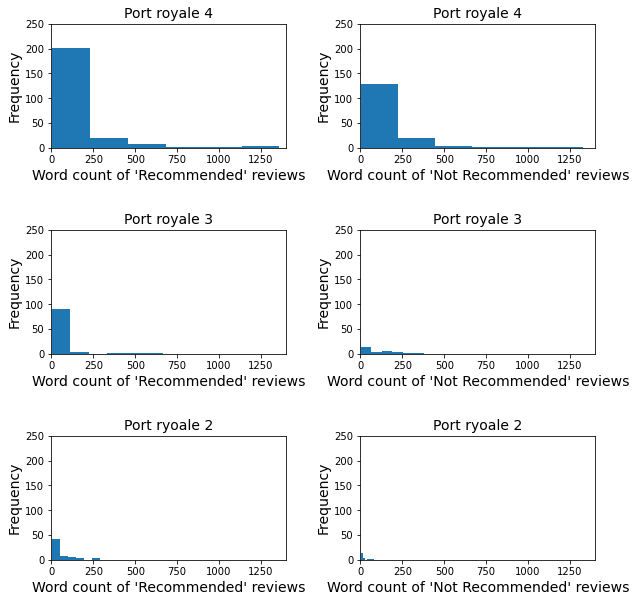

In [178]:
plot_word_count(recommend_df_L, not_recommend_df_L, game_name_L)

The word count analyses partly reflects the mixed rating nature of the game, Port royale 4, as the frequency of each plot is positively correlated with the number of reviews submitted.

The above plot actually suggests that the game successfully gains more popularity as more latest release is made, except the number of not recommended reviews grows much more significantly than the number or recommend reviews.

To get deeper, we analyze what players like and dislike.

In [179]:
import string
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [192]:
def clean_text(df):
    max_iter = len(df)
    #build a table to translate each punctuation to empty text.
    table = str.maketrans('', '', string.punctuation)
    #build a list of stopwords based on an existing library
    stop_words = stopwords.words('english')
    #for transforming each word into its root
    porter = PorterStemmer()
    for i in range(0,max_iter):
        text_raw_str = df.iloc[i]['Review']
        tokens = word_tokenize(text_raw_str)
        tokens_lower = [w.lower() for w in tokens]
        tokens_no_punct = [w.translate(table) for w in tokens_lower]
        words = [word for word in tokens_no_punct if word.isalpha()]
        words = [w for w in words if not w in stop_words]
        words_root = [porter.stem(word) for word in words]
        separator = ' '
        text_clean_str = separator.join(words_root)
        df.at[i, 'Review'] = text_clean_str
    return df

In [193]:
rec_clean_df_L = []
not_rec_clean_df_L = []
for df in recommend_df_L: rec_clean_df_L.append(clean_text(df))
for df in not_recommend_df_L: not_rec_clean_df_L.append(clean_text(df))

In [194]:
from sklearn.feature_extraction.text import CountVectorizer

#Please be aware that many of the text cleaning above can be done within
#CountVectorizer, except I am not familiair enough to CountVectorizer yet.

In [195]:
def word_count_vect(df):
    count_vect = CountVectorizer(ngram_range=(1,2),
                                stop_words=['game','ca','nt']).fit(df['Review'])

    words = count_vect.transform(df['Review'])
    #the total count for each identified vocabulary
    sum_words = words.sum(axis=0)

    word_count = []
    for word, index in count_vect.vocabulary_.items():
        word_count.append((word, sum_words[0, index]))

    sorted_word_count = sorted(word_count, key=lambda x: x[1],
                                reverse=True)

    return sorted_word_count

In [196]:
rec_word_count_L = []
not_rec_word_count_L = []
for df in rec_clean_df_L: rec_word_count_L.append(word_count_vect(df))
for df in not_rec_clean_df_L: not_rec_word_count_L.append(word_count_vect(df))

In [138]:
def plot_common_words(rec_word_count_L, not_rec_word_count_L, game_name_L):

    num_row = len(game_name_L)
    plt.figure(figsize=(20,20))
    j = num_row
    for i in range(0,num_row):
        k = i * 2 + 1
        #Let show only the top 20
        data_raw = rec_word_count_L[i][:20]
        x = []  #vocabulary
        y = []  #count
        for data in data_raw:
            x.append(data[0])
            y.append(data[1])

        plt.subplot(j,2,k)
        plt.title(game_name_L[i], fontsize=14)
        plt.barh(x, y)
        plt.ylabel('Feature frequency of \'Recommended\' reviews', fontsize=14)
        plt.xlim(0,250)
        plt.gca().invert_yaxis()
        plt.tight_layout(pad=3.0)

    for i in range(0,num_row):
        k = i * 2 + 2
        data_raw = not_rec_word_count_L[i][:20]
        x = []  #vocabulary
        y = []  #count
        for data in data_raw:
            x.append(data[0])
            y.append(data[1])

        plt.subplot(j,2,k)
        plt.title(game_name_L[i], fontsize=14)
        plt.barh(x, y)
        plt.ylabel('Feature frequency of \'Not Recommended\' reviews', fontsize=14)
        plt.xlim(0,250)
        plt.gca().invert_yaxis()
        plt.tight_layout(pad=3.0)

    plt.show()

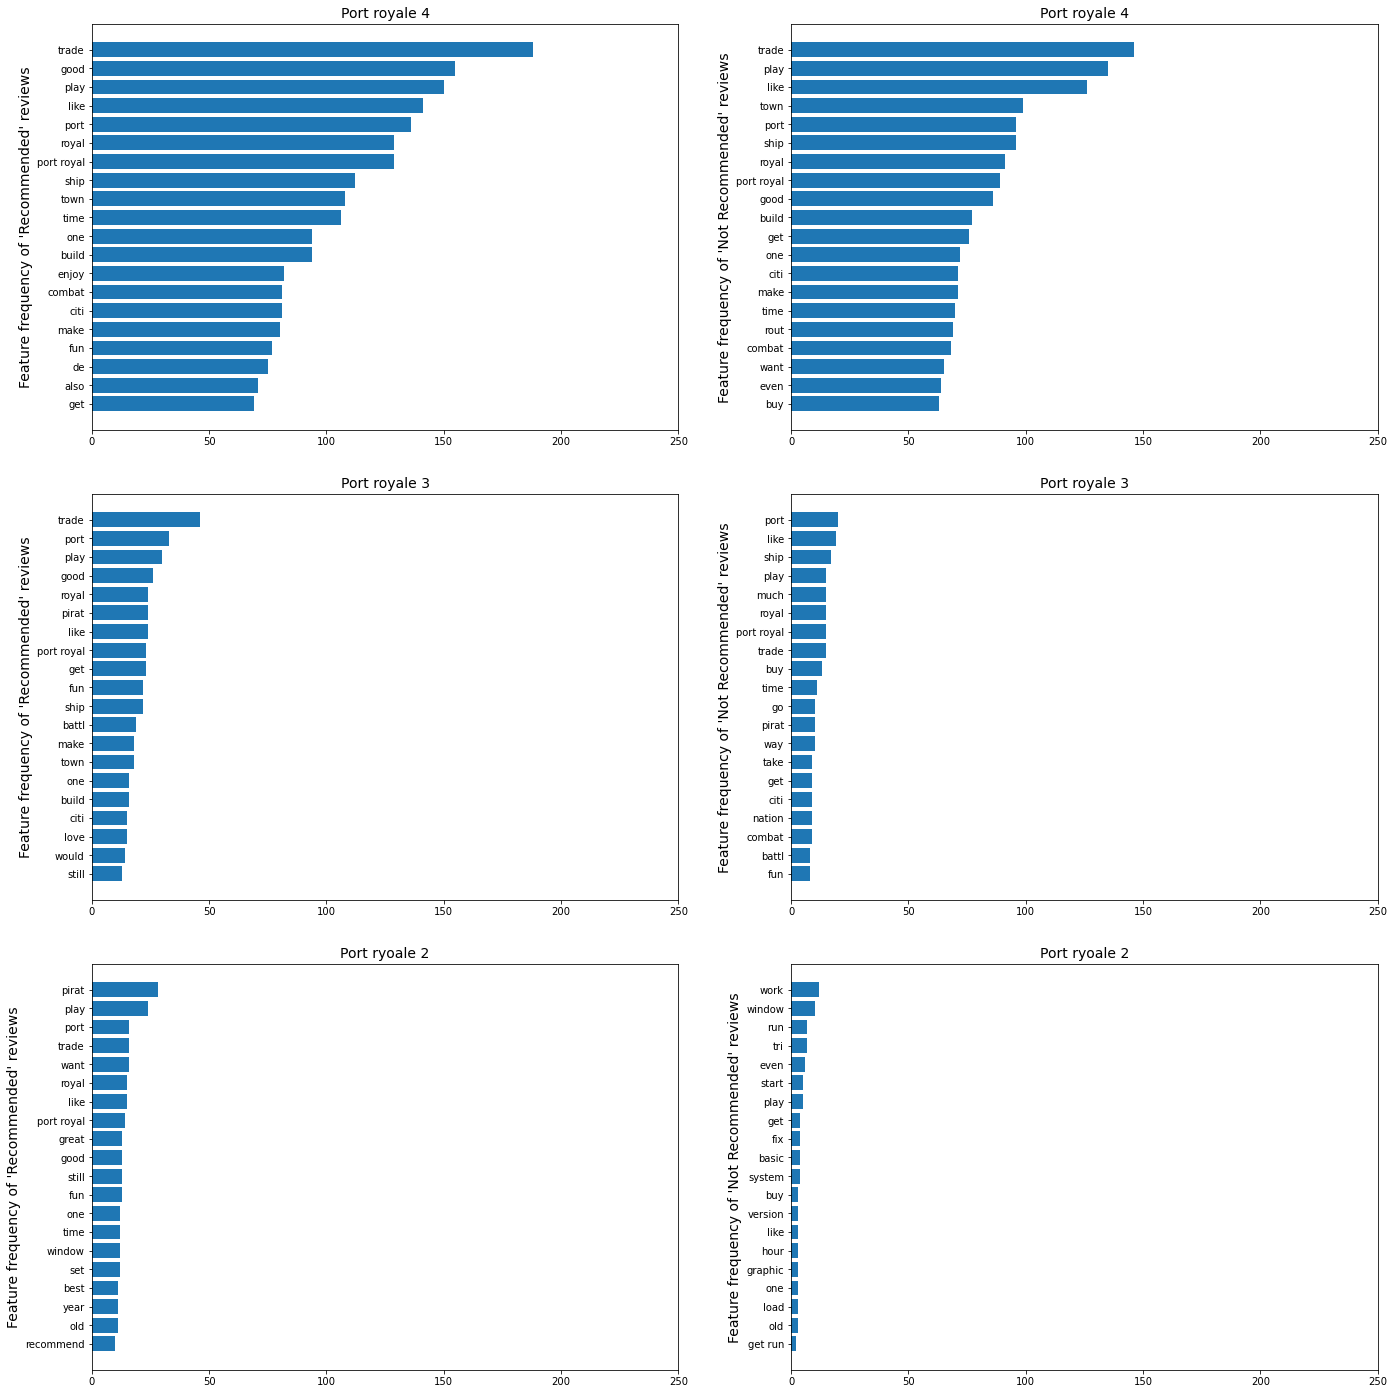

In [139]:
plot_common_words(rec_word_count_L, not_rec_word_count_L, game_name_L)

A quick look of the above figures give 2 interesting findings for our analyses:

1st, there are still many stop words, which are words that do not contribute to our understanding of the reviews, such as "also", "get", etc. This suggests a further expansion of the top words dictionary may help.

2nd, there are clear changes to a few identified features along the different release of this game series, as to be listed below:
     
   (a) The word "pirat". As a trading game on the ocean, this word likely refers to "pirate". We can see that this word is always among reviews for "Recommended" till Port royale 4, the latest release. This suggests that a past feature highly welcome by users is likely to be dropped or screwed up in the latest release. As a user myself, this is unfortunately true.
     
   (b) The word "combat" first appears in the "Not Recommended" side of Port Royale 3. However, in the lateast release, it appears on both  "Recommended" and "Not Recommended" sides, which its ranking on the "Recommended" side marginally higher than that on the "Not Recommended" side. This indicates a feature that likely gains a lot of improvements upon the latest release.
     
   (c) The word "trade" ranks number 1 for both  "Recommended" and "Not Recommended" sides at Port Royale 4, which never occurs before. This indicates that the latest release of the game may have implemented a new trading system that is highly controversial among users.

### TF-IDF

TF-IDF is a common measure to access the importance of each word in a document. Its evaluation involves measuring how frequent a word appears in a document and how frequent such a document is present among the piles of documents we are analyzing.
[More Details: https://en.wikipedia.org/wiki/Tf-idf]

As a standard analysis used on customers' reviews, we will apply this to our data to gain a bit more insights.

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [282]:
def apply_tfidf(df):
    tfvec = TfidfVectorizer(ngram_range=(1,2),
        stop_words=['game','ca','nt'],
        max_df=0.9,use_idf=True)

    #fit the model to the reviews
    s = tfvec.fit(df['Review'])
    score = tfvec.transform(df['Review'])
    score_mat = score.todense()
    score_L = score_mat.sum(axis=0)
    name_score_L = pd.DataFrame(score_L.T,
                index=tfvec.get_feature_names(),
                columns=['TD-IDF'])
    sorted_L = name_score_L.sort_values(by=['TD-IDF'],ascending=False)
    return sorted_L

In [283]:
rec_tfidf_L = []
not_rec_tfidf_L = []
for df in rec_clean_df_L: rec_tfidf_L.append(apply_tfidf(df))
for df in not_rec_clean_df_L: not_rec_tfidf_L.append(apply_tfidf(df))

In [291]:
print('Recommended features:')

for i in  range(0,3):
    print(game_name_L[i])
    print(rec_tfidf_L[i][:6])

print('Not Recommended features:')
for i in  range(0,3):
    print(game_name_L[i])
    print(not_rec_tfidf_L[i][:6])


Recommended features:
Port royale 4
         TD-IDF
good   7.956881
fun    7.786163
great  7.097759
like   6.981029
trade  6.226271
play   5.880311
Port royale 3
         TD-IDF
fun    4.740504
great  3.812736
trade  3.710984
good   3.193432
play   2.988642
love   2.945034
Port ryoale 2
           TD-IDF
good     3.427343
great    2.228650
love     2.201538
play     2.044295
economi  1.440413
year     1.421454
Not Recommended features:
Port royale 4
              TD-IDF
play        4.231746
port        3.817490
like        3.814916
royal       3.773275
port royal  3.758104
trade       3.737069
Port royale 3
              TD-IDF
port        1.410502
royal       1.235006
port royal  1.235006
bore        1.102369
ship        0.996763
like        0.945157
Port ryoale 2
               TD-IDF
work         3.173966
window       1.594225
work window  1.227490
even         1.148016
run          1.041576
start        1.008205


There seems to be not much  we can  learn from the above analyses. However, it is clear that the "trade" feature remains the most controversial item in Port Royale 4, while Port Royale 2 seems to suffer a lot from problems about running on windors.